In [1]:
version=2 # allow easier switching between old and new k-corrections (new jm k-ccorections = 2, old ajs = 1)

In [2]:
import astropy
from astropy.table import Table
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
import astropy.units as U

import numpy as np
import matplotlib.pyplot as plt

import os
import sys

# Setting up python paths to point to right location

print(os.environ['HOME'])
sys.path.append(os.environ['HOME'] + '/code/project_handover')
if version==2:
    ke_code_root = os.environ['HOME']+'/code/LSS/py/LSS/DESI_ke'
    os.environ['CODE_ROOT'] = ke_code_root
elif version==1:
    os.environ['CODE_ROOT'] = os.environ['HOME'] + '/DESI'

sys.path.append(os.environ['CODE_ROOT'])


/global/homes/e/edown


- apply different faint limits to N and S catalogues
- define minimum and maximum k-correction polynomials with g-r colour 0.130634 and 1.06731 (for bright and faint limits) respectively
- use vls.vol_lim_sample_2 for desired magnitude limits:
    - finds faintest and brightest apparent magnitude for each galaxy using lower and upper magnitude limit, max and min k-corrections (most conservative limits)
    - applies absolute magnitude cut: where M_r is between upper and lower magnitude limits
    - applies faint and bright limit cut for volume limited samples: where the 'faint apparent magnitude' is brighter than the N/S faint limit, and where the 'bright apparent magnitude' is fainter than the bright limit of r=15
    - returns mask to apply

In [3]:
import vol_lim_samples as vls

In [4]:
N = Table.read('/pscratch/sd/e/edown/DA02/LSS/guadalupe/LSScats/new_kcorrs/BGS_BRIGHT_N_clustering.dat.fits')
S = Table.read('/pscratch/sd/e/edown/DA02/LSS/guadalupe/LSScats/new_kcorrs/BGS_BRIGHT_S_clustering.dat.fits')
N_rand = Table.read('/pscratch/sd/e/edown/DA02/LSS/guadalupe/LSScats/new_kcorrs/BGS_BRIGHT_N_1_clustering.ran.fits')
S_rand = Table.read('/pscratch/sd/e/edown/DA02/LSS/guadalupe/LSScats/new_kcorrs/BGS_BRIGHT_S_1_clustering.ran.fits')
# N = Table.read('/global/cfs/cdirs/desi/survey/catalogs/DA02/LSS/guadalupe/LSScats/test/BGS_BRIGHT_N_clustering.dat.fits')
# S = Table.read('/global/cfs/cdirs/desi/survey/catalogs/DA02/LSS/guadalupe/LSScats/test/BGS_BRIGHT_S_clustering.dat.fits') #OLD CATALOGUE - REMOVE WHEN PERLMUTTER WORKING
# N_rand = Table.read('/global/cfs/cdirs/desi/survey/catalogs/DA02/LSS/guadalupe/LSScats/test/BGS_BRIGHT_N_1_clustering.ran.fits')
# S_rand = Table.read('/global/cfs/cdirs/desi/survey/catalogs/DA02/LSS/guadalupe/LSScats/test/BGS_BRIGHT_S_1_clustering.ran.fits')
N['FAINT_RLIM'] = 19.539993
S['FAINT_RLIM'] = 19.5
N['ZLIM_UPPER'] = 0.5
S['ZLIM_UPPER'] = 0.5
N['PHOTSYS'] = 'N'
S['PHOTSYS'] = 'S'
A_N = 705.5096
A_S = 1160.9628

A = A_N + A_S
N['AREA'] = A_N
S['AREA'] = A_N
S['REST_GMR_0P1'] += 0.025

In [5]:
N

TARGETID,Z,RA,DEC,PHOTSYS,NTILE,TILES,WEIGHT,WEIGHT_ZFAIL,WEIGHT_COMP,WEIGHT_SYS,flux_g_dered,flux_r_dered,flux_z_dered,flux_w1_dered,flux_w2_dered,REST_GMR_0P1,KCORR_R0P1,KCORR_G0P1,KCORR_R0P0,KCORR_G0P0,REST_GMR_0P0,EQ_ALL_0P0,EQ_ALL_0P1,ABSMAG_RP1,ABSMAG_RP0,NZ,WEIGHT_FKP,FAINT_RLIM,ZLIM_UPPER,AREA
int64,float64,float64,float64,bytes1,int64,bytes11,float64,float64,float64,float64,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
39633366047264069,0.23373774756268273,268.6773406567538,58.196956322063585,N,1,20001,4.0275952453516695,1.0068988113379174,4.0,1.0,5.1988206,18.016794,36.307766,35.975773,23.484913,0.9601794331236166,-0.008527691669446225,0.3807248667842408,0.0,0.0,0.0,0.0,-0.22672561513580225,-19.96034729315174,0.0,0.00820900032369279,0.03406895657423148,19.539993,0.5,705.5096
39633366047264297,0.16095951646742163,268.7008850398322,58.31651750837625,N,1,20001,2.117383080798565,1.0586915403992825,2.0,1.0,7.7169294,16.809292,28.698618,21.945616,12.552565,0.7151128655631005,-0.11683325338677561,0.013316408515950395,0.0,0.0,0.0,0.0,-0.15613073097339897,-18.94630942108295,0.0,0.017794268164337358,0.016010805430020397,19.539993,0.5,705.5096
39633366047264412,0.2262081883049673,268.7121644210125,58.17137871856034,N,1,20001,8.039997580306183,1.004999697538273,8.0,1.0,5.6451545,17.743734,36.715954,42.338474,30.138641,0.9052296043034167,-0.028153563916621993,0.31003838634539116,0.0,0.0,0.0,0.0,-0.21942194265581827,-19.851344536436464,0.0,0.00820900032369279,0.03406895657423148,19.539993,0.5,705.5096
39633366047264487,0.10750217420934505,268.72025843577376,58.150995263304566,N,1,20001,2.0032763081059697,1.0016381540529848,2.0,1.0,65.581665,164.53503,310.0892,251.75818,156.65999,0.956521301759511,-0.17295453844881334,-0.13078618871906156,0.0,0.0,0.0,0.0,-0.10427710898306469,-20.469401053619965,0.0,0.02657715397623152,0.010776774943308927,19.539993,0.5,705.5096
39633366047264710,0.20509598282456507,268.7447179685751,58.35164090788789,N,1,20001,3.1725075550213915,1.0575025183404638,3.0,1.0,9.199382,18.115196,31.323214,38.144897,31.80481,0.5610827423376682,-0.10324069390941726,0.07138670779588333,0.0,0.0,0.0,0.0,-0.19894310333982812,-19.580757877102958,0.0,0.01136807299529503,0.02483667685249208,19.539993,0.5,705.5096
39633366047265345,0.23282678015147948,268.81269831707334,58.142903267925234,N,1,20001,1.002954413911919,1.002954413911919,1.0,1.0,5.7025113,20.790937,44.397903,52.077763,37.31693,1.0111275395410955,-0.003718400029718072,0.38967409521922547,0.0,0.0,0.0,0.0,-0.2258419767469351,-20.111968029552685,0.0,0.00820900032369279,0.03406895657423148,19.539993,0.5,705.5096
39633366047265059,0.18293134246555096,268.78466388262035,58.36109277746728,N,1,20001,1.0087182299042126,1.0087182299042126,1.0,1.0,16.68374,31.437498,50.411964,43.284397,33.23363,0.5465122556491973,-0.11735636948124453,0.024018566641961336,0.0,0.0,0.0,0.0,-0.17744340219158442,-19.9104989315704,0.0,0.013850629321330651,0.020476158666134885,19.539993,0.5,705.5096
39633366051456481,0.2921522504545623,268.9829065999235,58.3056335434302,N,1,20001,2.015101288698258,1.007550644349129,2.0,1.0,12.465097,30.888058,55.453087,60.664528,37.495365,0.6678858133371675,-0.01005370182576118,0.30729760641910264,0.0,0.0,0.0,0.0,-0.2833876829409254,-21.038632610684793,0.0,0.004623023860090817,0.05893796032634171,19.539993,0.5,705.5096
39633366047265062,0.22913931839469825,268.78498910544477,58.22941912184547,N,1,20001,2.0050073092652934,1.0025036546326467,2.0,1.0,9.368853,30.154222,56.5326,57.30369,32.62352,0.9163761681834897,-0.022833601168915918,0.32994382561830077,0.0,0.0,0.0,0.0,-0.2222651388428573,-20.461048394848664,0.0,0.00820900032369279,0.03406895657423148,19.539993,0.5,705.5096


In [6]:
z_range = np.linspace(0.0,0.6,100) 

e_z = -0.97*(z_range - 0.0)
#E(z) =−Q0(z−zref), Q0,all= 0.97 McNaught-Roberts 2014 dQ0,blue= 2.12±0.22andQ0,red= 0.80±0.26.

In [7]:
from smith_kcorr import GAMA_KCorrection
if version==2:
    raw_dir = os.environ['CODE_ROOT'] + '/data/'
    kcorr_r_N = GAMA_KCorrection(band='R', file='jmext', photsys='N')
    kcorr_r_S = GAMA_KCorrection(band='R', file='jmext', photsys='S')
    k_corr_file = raw_dir + '/jmext_kcorr_N_rband_z01.dat'
    col_min, col_max, A, B, C, D, E, col_med = np.loadtxt(k_corr_file, unpack=True)

    # reverse array to keep order
    col_med =col_med[::-1]
   
    colours_jmext_N = [np.ones(len(z_range))*col_med[0],np.ones(len(z_range))*col_med[1],np.ones(len(z_range))* col_med[2],
                       np.ones(len(z_range))*col_med[3],np.ones(len(z_range))*col_med[4],np.ones(len(z_range))*col_med[5],
                       np.ones(len(z_range))* col_med[6]]
   
    k_corr_file = raw_dir + '/jmext_kcorr_S_rband_z01.dat'
    col_min, col_max, A, B, C, D, E, col_med = np.loadtxt(k_corr_file, unpack=True)

    # reverse array to keep order
    col_med =col_med[::-1]
   
    colours_jmext_S = [np.ones(len(z_range))*col_med[0],np.ones(len(z_range))*col_med[1],np.ones(len(z_range))*col_med[2],
                       np.ones(len(z_range))*col_med[3],np.ones(len(z_range))*col_med[4],np.ones(len(z_range))*col_med[5],
                       np.ones(len(z_range))*col_med[6]]
    
    #zref_N = 0.138
    #zref_S = 0.138 #0.111
    
    kr_max_N = kcorr_r_N.k(z_range, colours_jmext_N[0])
    kr_max_S = kcorr_r_S.k(z_range, colours_jmext_S[0])
    kr_1_N = kcorr_r_N.k(z_range, colours_jmext_N[1])
    kr_2_N = kcorr_r_N.k(z_range, colours_jmext_N[2])
    kr_3_N = kcorr_r_N.k(z_range, colours_jmext_N[3])
    kr_4_N = kcorr_r_N.k(z_range, colours_jmext_N[4])
    kr_5_N = kcorr_r_N.k(z_range, colours_jmext_N[5])
    kr_1_S = kcorr_r_S.k(z_range, colours_jmext_S[1])
    kr_2_S = kcorr_r_S.k(z_range, colours_jmext_S[2])
    kr_3_S = kcorr_r_S.k(z_range, colours_jmext_S[3])
    kr_4_S = kcorr_r_S.k(z_range, colours_jmext_S[4])
    kr_5_S = kcorr_r_S.k(z_range, colours_jmext_S[5])
    kr_min_N = kcorr_r_N.k(z_range, colours_jmext_N[6])
    kr_min_S = kcorr_r_S.k(z_range, colours_jmext_S[6])
    
elif version==1:
    kcorr_r_N = GAMA_KCorrection(band='R') # old version of k-corrections (not N/S dependent)
    kcorr_r_S = GAMA_KCorrection(band='R')

    colours_ajs = [np.ones(len(z_range))*1.06731,np.ones(len(z_range))*0.933226,np.ones(len(z_range))* 0.784644,np.ones(len(z_range))*0.603434,
               np.ones(len(z_range))* 0.443336,np.ones(len(z_range))*0.298124,np.ones(len(z_range))*0.130634]

    kr_max_N = kcorr_r_N.k(z_range, colours_jmext[0])
    kr_max_S = kcorr_r_S.k(z_range, colours_jmext[0])
    kr_1 = kcorr_r_N.k(z_range, colours_jmext[1])
    kr_2 = kcorr_r_N.k(z_range, colours_jmext[2])
    kr_3 = kcorr_r_N.k(z_range, colours_jmext[3])
    kr_4 = kcorr_r_N.k(z_range, colours_jmext[4])
    kr_5 = kcorr_r_N.k(z_range, colours_jmext[5])
    kr_min_N = kcorr_r_N.k(z_range, colours_jmext[6])
    kr_min_S = kcorr_r_S.k(z_range, colours_jmext[6])

faintlim_N = vls.absmag(19.539993, z_range, kr_max_N, e_z)
faintlim_S = vls.absmag(19.5, z_range, kr_max_S, e_z)
brightlim_N = vls.absmag(15, z_range, kr_min_N, e_z)
brightlim_S = vls.absmag(15, z_range, kr_min_S, e_z)

/global/homes/e/edown/code/project_handover/vol_lim_samples.py:22: RuntimeWarning: divide by zero encountered in log10
  return appmag - 5*np.log10(cosmo.luminosity_distance(np.array(z)).to_value()) - 25 - k - e


In [8]:
if version==2:
    N['KMIN'] = kcorr_r_N.k(N['Z'], np.ones(len(N['Z']))*0.39861392974853516) # k-correction for galaxy's redshift but bluest colour
    N['KMAX'] = kcorr_r_N.k(N['Z'], np.ones(len(N['Z']))*0.9832057952880859) # k-correction for galaxy's redshift but reddest colour
    S['KMIN'] = kcorr_r_S.k(S['Z'], np.ones(len(S['Z']))*0.4014892578125) # k-correction for galaxy's redshift but bluest colour
    S['KMAX'] = kcorr_r_S.k(S['Z'], np.ones(len(S['Z']))*0.9937572479248047) # k-correction for galaxy's redshift but reddest colour(for conservative faint  limit)
    
    # N['K_R0P0'] = kcorr_r_N.k_nonnative_zref(0.14, N['Z'], N['REST_GMR_0P1'])
    # S['K_R0P0'] = kcorr_r_S.k_nonnative_zref(0.14, S['Z'], S['REST_GMR_0P1'])
elif version==1:
    N['KMIN'] = kcorr_r_N.k(N['Z'], np.ones(len(N['Z']))*0.130634) # k-correction for galaxy's redshift but bluest colour
    N['KMAX'] = kcorr_r_N.k(N['Z'], np.ones(len(N['Z']))*1.06731) # k-correction for galaxy's redshift but reddest colour
    S['KMIN'] = kcorr_r_S.k(S['Z'], np.ones(len(S['Z']))*0.130634) # k-correction for galaxy's redshift but bluest colour
    S['KMAX'] = kcorr_r_S.k(S['Z'], np.ones(len(S['Z']))*1.06731) # k-correction for galaxy's redshift but reddest colour(for conservative faint  limit)"""

In [9]:
data = Table(np.hstack((N, S)))
data.dtype.names
data['ZMIN'] = np.ones(len(data))
data['ZMAX'] = np.ones(len(data))

In [10]:
rand = Table(np.hstack((np.array(N_rand),np.array( S_rand))))

In [11]:
from   astropy.table import Table, vstack, hstack, join

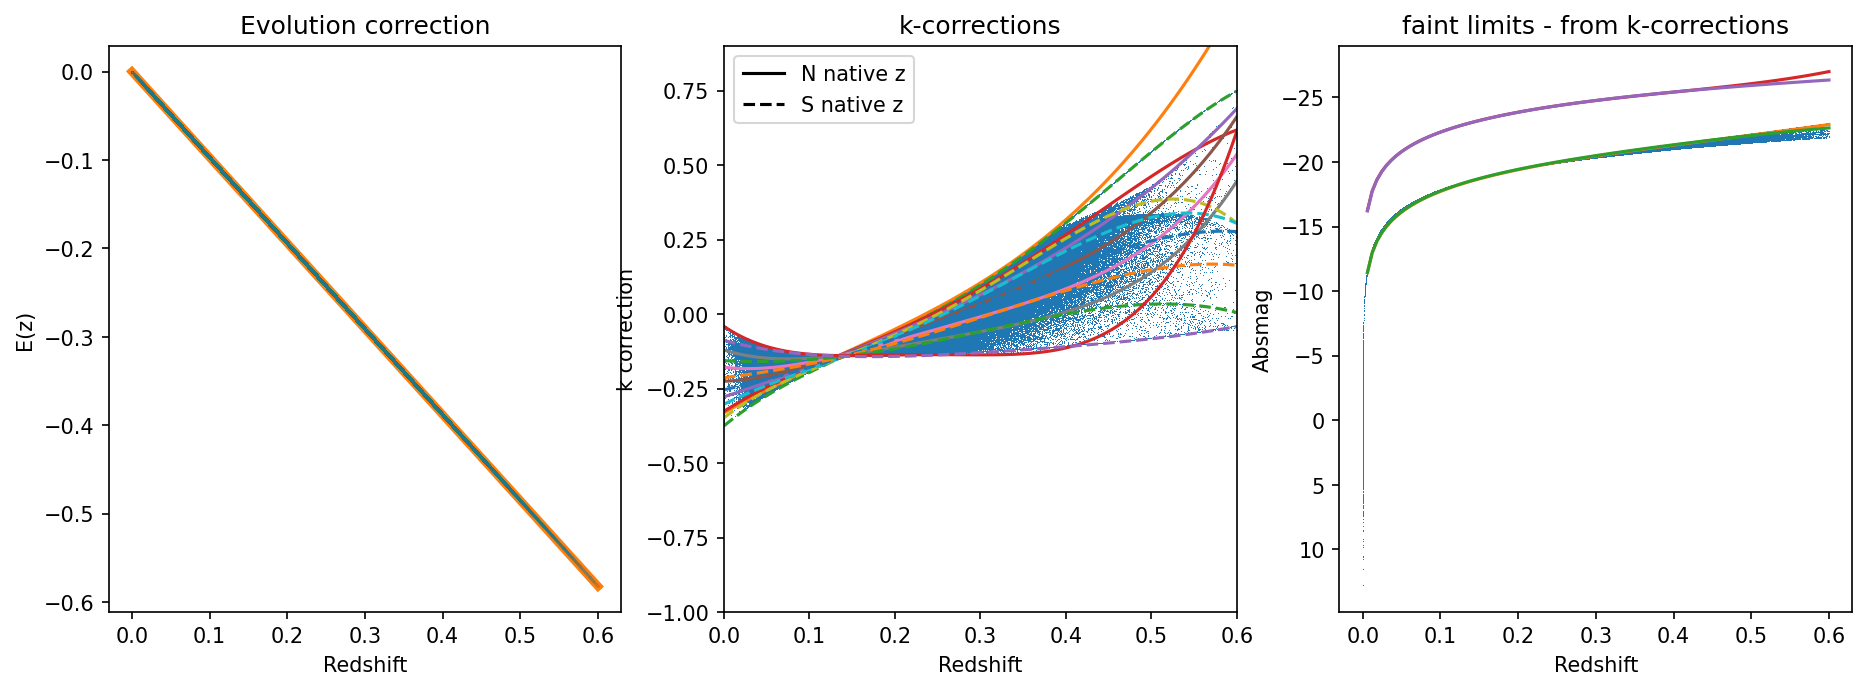

In [13]:
plt.rcParams['font.size'] = 10
plt.figure(figsize=(15,5), dpi=150)

plt.subplot(131)
plt.title('Evolution correction')
plt.plot(z_range, e_z, label='linear fit', color='tab:orange', lw=4)
plt.plot(data['Z'], data['EQ_ALL_0P1'], lw=0, marker='o', color='tab:blue', markersize=0.01)
plt.xlabel('Redshift')
plt.ylabel('E(z)')

plt.subplot(132)
plt.title('k-corrections')

import matplotlib as mpl
colormap = plt.cm.coolwarm
normalize = mpl.colors.Normalize(vmin=0.2, vmax=1.4)

plt.plot(data['Z'], data['KCORR_R0P1'], lw=0, marker=',')
plt.plot(z_range, kr_max_N, ls='-')
plt.plot(z_range, kr_max_S, ls='--')
plt.plot(z_range, kr_1_N, ls='-')
plt.plot(z_range, kr_2_N, ls='-')
plt.plot(z_range, kr_3_N, ls='-')
plt.plot(z_range, kr_4_N, ls='-')
plt.plot(z_range, kr_5_N, ls='-')
plt.plot(z_range, kr_1_S, ls='--')
plt.plot(z_range, kr_2_S, ls='--')
plt.plot(z_range, kr_3_S, ls='--')
plt.plot(z_range, kr_4_S, ls='--')
plt.plot(z_range, kr_5_S, ls='--')
plt.plot(z_range, kr_min_N, ls='-')
plt.plot(z_range, kr_min_S, ls='--')
plt.plot(np.nan,np.nan,color='k', ls='-', label='N native z')
plt.plot(np.nan,np.nan,color='k', ls='--', label='S native z')
plt.legend()
plt.ylim(-1,0.9)
plt.xlabel('Redshift')
plt.ylabel('k correction')
plt.xlim(0,0.6)
plt.subplot(133)
plt.title('faint limits - from k-corrections')
plt.plot(data['Z'], vls.absmag(19.5, np.array(data['Z']), np.array(data['KCORR_R0P1']), np.array(data['EQ_ALL_0P1'])),lw=0,marker=',')
plt.plot(z_range, faintlim_N, label='faint limit, N')
plt.plot(z_range, faintlim_S, label='faint limit, S')
plt.plot(z_range, brightlim_N, label='bright limit N')
plt.plot(z_range, brightlim_S, label='bright limit S')
plt.gca().invert_yaxis()

plt.xlabel('Redshift')
plt.ylabel('Absmag')
plt.show()

Evolution correction is linear function.

K-corrections are polynomials that are different to take account of N/S photometric differences

Faint limits used to define volume-limited samples:
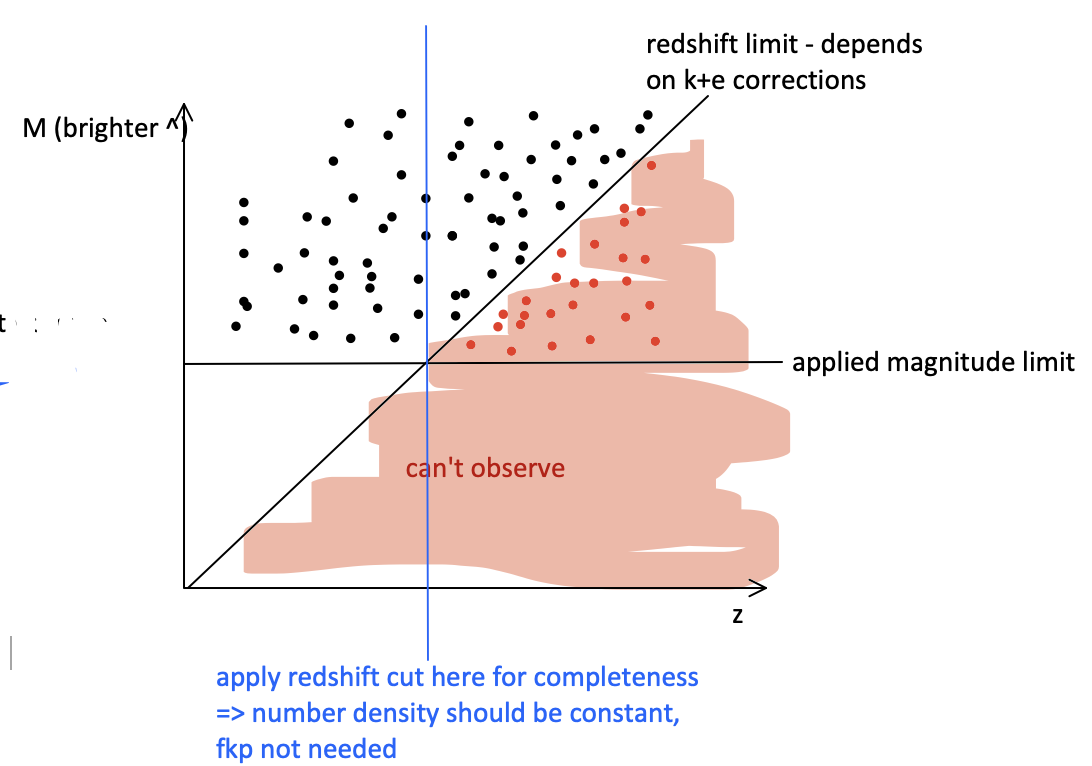

In [15]:
sample1617 = vls.vol_lim_sample_2(-16,-17, data) # function for defining volume-limited samples given absolute magnitude limits and a table
sample1718 = vls.vol_lim_sample_2(-17,-18, data) # you should probably work out your own way of doing this as k-correction code likely to have changed
sample1819 = vls.vol_lim_sample_2(-18,-19, data)
sample1920 = vls.vol_lim_sample_2(-19,-20, data)
sample2021 = vls.vol_lim_sample_2(-20,-21, data)
sample2122 = vls.vol_lim_sample_2(-21,-22, data)
sample2223 = vls.vol_lim_sample_2(-22,-23, data)

In [16]:
data_1617 = data[sample1617]
data_1718 = data[sample1718]
data_1819 = data[sample1819]
data_1920 = data[sample1920]
data_2021 = data[sample2021]
data_2122 = data[sample2122]
data_2223 = data[sample2223]

In [17]:
print(len(data_2223), len(data_2122), len(data_2021), len(data_1920), len(data_1819), len(data_1718), len(data_1617))

15887 98050 150488 94219 39495 15228 6300


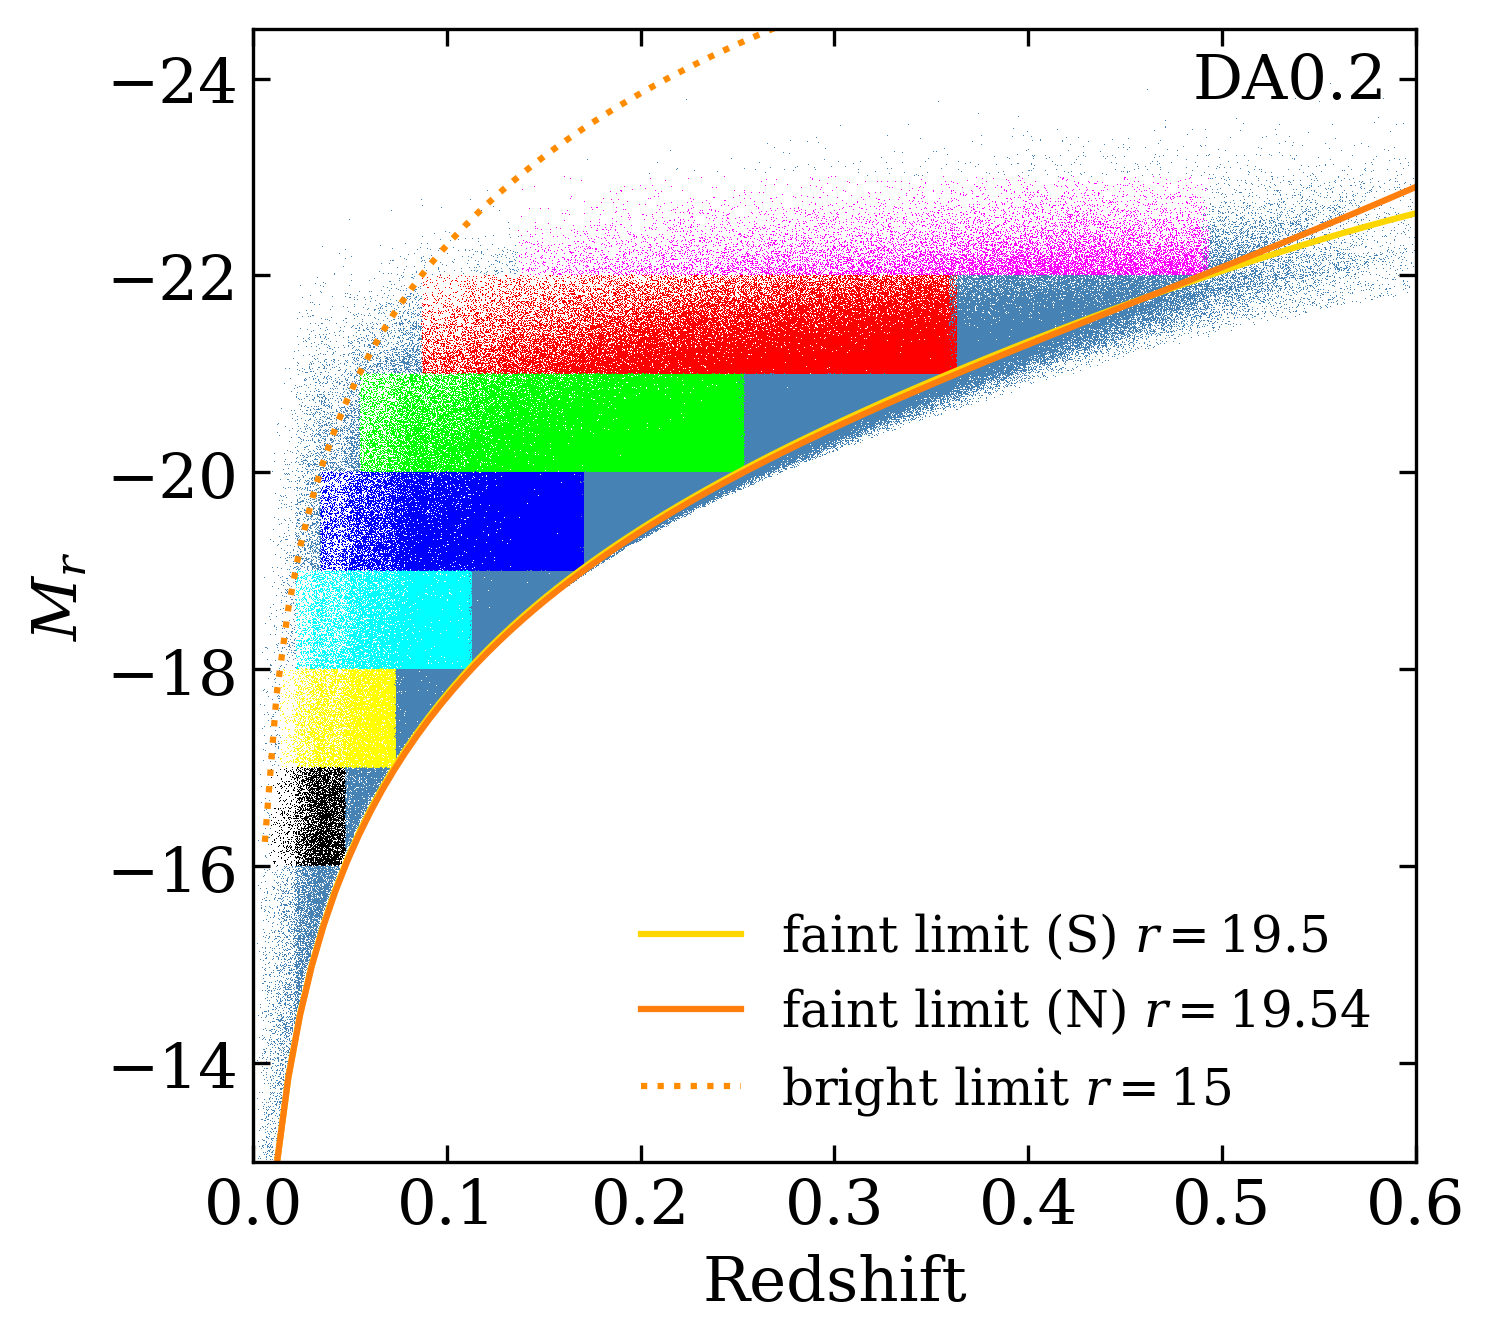

In [18]:
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams['font.size'] = 15

fig, ax1 = plt.subplots(figsize=(5,5), dpi=300)

ax1.plot(data['Z'], data['ABSMAG_RP1'], lw=0, marker=',', color='steelblue',zorder=0)

plt.xlabel('Redshift')
plt.ylabel('$M_{r}$')
ax1.plot(data['Z'][sample1617], data['ABSMAG_RP1'][sample1617], lw=0, marker=',', color='k', zorder=1)
ax1.plot(data['Z'][sample1718], data['ABSMAG_RP1'][sample1718], lw=0, marker=',', color='yellow', zorder=1)
ax1.plot(data['Z'][sample1819], data['ABSMAG_RP1'][sample1819], lw=0, marker=',', color='cyan', zorder=1)
ax1.plot(data['Z'][sample1920], data['ABSMAG_RP1'][sample1920], lw=0, marker=',', color='blue', zorder=1)
ax1.plot(data['Z'][sample2021], data['ABSMAG_RP1'][sample2021], lw=0, marker=',', color='lime', zorder=1)
ax1.plot(data['Z'][sample2122], data['ABSMAG_RP1'][sample2122], lw=0, marker=',', color='red', zorder=1)
ax1.plot(data['Z'][sample2223], data['ABSMAG_RP1'][sample2223], lw=0, marker=',', color='magenta', zorder=1)
ax1.plot(z_range, faintlim_S, color='gold', ls ='-', label='faint limit (S) $r=19.5$', zorder=2)
ax1.plot(z_range, faintlim_N, color='tab:orange', ls='-', label='faint limit (N) $r=19.5$4', zorder=2)
ax1.plot(z_range, brightlim_N, color='darkorange', ls=':', label='bright limit $r=15$', zorder=2)

plt.ylim(-24.5,-13)
plt.xlim(0,0.6)
ax1.tick_params(axis='both', which='major', direction='in', top=True, right=True, length=4)

plt.gca().invert_yaxis()
plt.xlabel('Redshift')
plt.legend(loc='lower right', fontsize=12, frameon=False)
plt.text(0.485,-23.8,'DA0.2')

plt.show()

verify working for N/S

In [19]:
N_1718 = vls.vol_lim_sample_2(-17,-18, N)
N_1819 = vls.vol_lim_sample_2(-18,-19, N)
N_1920 = vls.vol_lim_sample_2(-19,-20, N)
N_2021 = vls.vol_lim_sample_2(-20,-21, N)
N_2122 = vls.vol_lim_sample_2(-21,-22, N)
N_2223 = vls.vol_lim_sample_2(-22,-23, N)

S_1718 = vls.vol_lim_sample_2(-17,-18, S)
S_1819 = vls.vol_lim_sample_2(-18,-19, S)
S_1920 = vls.vol_lim_sample_2(-19,-20, S)
S_2021 = vls.vol_lim_sample_2(-20,-21, S)
S_2122 = vls.vol_lim_sample_2(-21,-22, S)
S_2223 = vls.vol_lim_sample_2(-22,-23, S)

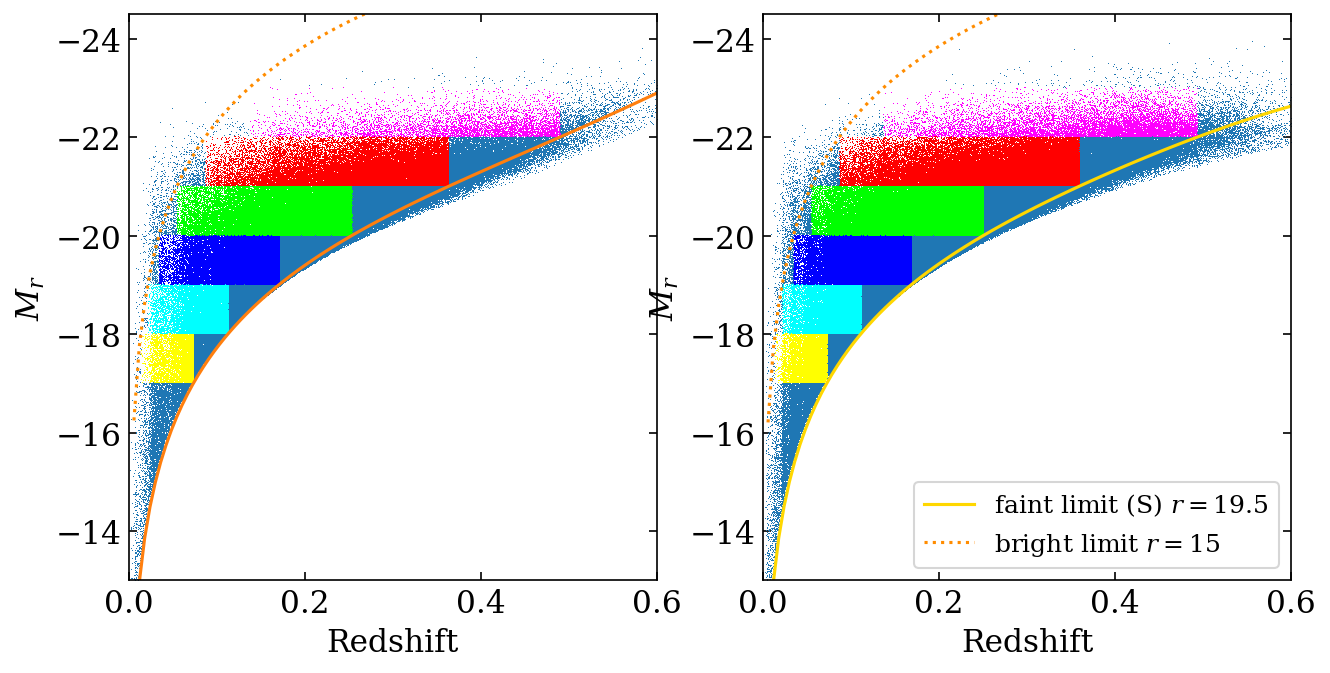

In [22]:
plt.figure(figsize=(10,5), dpi=150)

ax1 = plt.subplot(121)

ax1.plot(N['Z'], N['ABSMAG_RP1'], lw=0, marker=',')

plt.xlabel('Redshift')
plt.ylabel('$M_{r}$')

ax1.plot(N['Z'][N_1718], N['ABSMAG_RP1'][N_1718], lw=0, marker=',', color='yellow')
ax1.plot(N['Z'][N_1819], N['ABSMAG_RP1'][N_1819], lw=0, marker=',', color='cyan')
ax1.plot(N['Z'][N_1920], N['ABSMAG_RP1'][N_1920], lw=0, marker=',', color='blue')
ax1.plot(N['Z'][N_2021], N['ABSMAG_RP1'][N_2021], lw=0, marker=',', color='lime')
ax1.plot(N['Z'][N_2122], N['ABSMAG_RP1'][N_2122], lw=0, marker=',', color='red')
ax1.plot(N['Z'][N_2223], N['ABSMAG_RP1'][N_2223], lw=0, marker=',', color='magenta')
ax1.plot(z_range, faintlim_N, color='tab:orange', ls='-', label='faint limit (N) $r=19.5$4')
ax1.plot(z_range, brightlim_N, color='darkorange', ls=':', label='bright limit $r=15$')
plt.ylim(-24.5,-13)
plt.xlim(0,0.6)
ax1.tick_params(axis='both', which='major', direction='in', top=True, right=True, length=4)

plt.gca().invert_yaxis()
plt.xlabel('Redshift')

ax2 = plt.subplot(122)
ax2.plot(S['Z'], S['ABSMAG_RP1'], lw=0, marker=',')

plt.xlabel('Redshift')
plt.ylabel('$M_{r}$')

ax2.plot(S['Z'][S_1718], S['ABSMAG_RP1'][S_1718], lw=0, marker=',', color='yellow')
ax2.plot(S['Z'][S_1819], S['ABSMAG_RP1'][S_1819], lw=0, marker=',', color='cyan')
ax2.plot(S['Z'][S_1920], S['ABSMAG_RP1'][S_1920], lw=0, marker=',', color='blue')
ax2.plot(S['Z'][S_2021], S['ABSMAG_RP1'][S_2021], lw=0, marker=',', color='lime')
ax2.plot(S['Z'][S_2122], S['ABSMAG_RP1'][S_2122], lw=0, marker=',', color='red')
ax2.plot(S['Z'][S_2223], S['ABSMAG_RP1'][S_2223], lw=0, marker=',', color='magenta')
ax2.plot(z_range, faintlim_S, color='gold', ls ='-', label='faint limit (S) $r=19.5$')
ax2.plot(z_range, brightlim_S, color='darkorange', ls=':', label='bright limit $r=15$')

plt.ylim(-24.5,-13)
plt.xlim(0,0.6)
ax2.tick_params(axis='both', which='major', direction='in', top=True, right=True, length=4)

plt.gca().invert_yaxis()
plt.xlabel('Redshift')


plt.legend(loc='lower right', fontsize=12)
plt.show()